# signswishで2値トレーニング

In [1]:
# paperspace gradient用
! rm -rf MOD2NN
! git clone https://$$TOKEN@github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/notebooks/MOD2NN')

Cloning into 'MOD2NN'...
remote: Enumerating objects: 1489, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 1489 (delta 140), reused 175 (delta 85), pack-reused 1235
Receiving objects: 100% (1489/1489), 42.07 MiB | 24.08 MiB/s, done.
Resolving deltas: 100% (845/845), done.


In [2]:
import time
import os
import json
import sys
import re
import glob
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Faraday.two_dim.module.lib.layers import *
from Faraday.two_dim.module.lib import regularizer

tf.random.set_seed(1)

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.9.1
Python: 3.9.13 (main, May 23 2022, 22:01:06) 
[GCC 9.4.0]


In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
#@title デフォルトのタイトル テキスト
wavelength = 633.0e-9 #@param {type:"number"}
d = 1.0e-6 #@param {type:"number"}
n = 1.5 #@param {type:"number"}
z = 0.7e-3 #@param {type:"number"}

In [14]:
def create_model(**kwargs):
    shape = (100, 100)
    theta = kwargs["theta"]
    eta = 0.
    l1=1.0e-6
    tf.random.set_seed(kwargs["seed"])
    inputs = tf.keras.Input((28, 28))
    x = ImageResizing(shape)(inputs)
    x = IntensityToElectricField(shape)(x)
    x = BinarizedMO(shape, theta=theta, eta=eta, beta=5.)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = BinarizedMO(shape, theta=theta, eta=eta, beta=5.)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = BinarizedMO(shape, theta=theta, eta=eta, beta=5.)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = BinarizedMO(shape, theta=theta, eta=eta, beta=5.)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = BinarizedMO(shape, theta=theta, eta=eta, beta=5.)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = ElectricFieldToIntensity(shape)(x)
    x = MNISTDetector(shape)(x)
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs, x)
    return model

In [17]:
def train(seed, theta, num):
    model_name = "20221021_" + str(num)
    cholab_path = "/content/drive/MyDrive/D2NN/"
    checkpoint_path = "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    path = "trained_model/"+ model_name

    model = create_model(seed=seed, theta=theta)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,  # category: sparse_categorical_crossentropy
                  metrics=["accuracy"]
                  )

    epochs = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=0.0002,
            patience=2,
        )

    def lr_schedule(epoch):
      """
      Returns a custom learning rate that decreases as epochs progress.
      """
      start = 0.2
      end = 0.0001
      n = 50
      a = -1/(n-1) * np.log(end/start)
      return np.exp(-a*(epoch)) * start
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(cholab_path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[cp_callback, tensorboard_callback]
                       )

    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")



    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

In [18]:
train(seed=1, theta=np.pi/100., num=1)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing_4 (ImageResi  (None, 100, 100)         0         
 zing)                                                           
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _4 (IntensityToElectricFiel                                     
 d)                                                              
                                                                 
 binarized_mo_15 (BinarizedM  (None, 2, 100, 100)      10000     
 O)                                                              
                                                                 
 angular_spectrum_15 (Angula  (None, 2, 100, 100)      0   

INFO:tensorflow:Assets written to: trained_model/20221021_1/assets


INFO:tensorflow:Assets written to: trained_model/20221021_1/assets


In [19]:
model = tf.keras.models.load_model("/notebooks/trained_model/20221021_1")

In [20]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.5151 - accuracy: 0.8616


[0.5151016712188721, 0.8615999817848206]

## 書き込み誤差
### 反転

In [43]:
weights = model.get_weights()

b_weights = [np.where(ary >= 0, 1, -1) for ary in weights]

In [45]:
from scipy import stats

seeds = np.arange(1, 11)
p = np.arange(0, 1.1, 0.1)
acc_table = np.zeros((len(seeds), len(p)))
loss_table = np.zeros((len(seeds), len(p)))

for j, _p in enumerate(p):
  for k, seed in enumerate(seeds):
    for i, b_weight in enumerate(b_weights):
        np.random.seed(seed)
        bi_dist = stats.bernoulli.rvs(p=_p, size=(100,100)) * 2 - 1
        weights[i] = b_weight * bi_dist

    model.set_weights(weights)
    bi_eval = model.evaluate(x_test, y_test)
    acc_table[k, j] = bi_eval[1]
    loss_table[k, j] = bi_eval[0]

313/313 [==============================] - 3s 8ms/step - loss: 0.5151 - accuracy: 0.8616


In [48]:
acc_df = pd.DataFrame(acc_table, columns=["{:.1f}".format(t) for t in p])
loss_df = pd.DataFrame(loss_table, columns=["{:.1f}".format(t)  for t in p])
acc_df.to_csv("acc.csv")
loss_df.to_csv("loss.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'out/fig2.png'

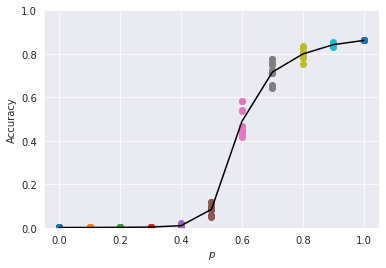

In [49]:
ave = np.average(acc_df.values, axis=0)
for i in range(acc_df.shape[1]):
    x = np.ones_like(acc_df.values[:,i]) * float(acc_df.columns[i])
    y = acc_df.values[:,i]
    plt.scatter(x, y, label=r"$p={:.1f}$".format(float(acc_df.columns[i])))

plt.plot([float(_p) for _p in acc_df.columns], ave, label="average", color="black")
plt.ylim(0., 1.)
plt.ylabel("Accuracy")
plt.xlabel("$p$")
plt.rcParams['figure.subplot.bottom'] = 0.2
plt.rcParams['figure.subplot.left'] = 0.2
#plt.legend()
plt.savefig("out/fig2.png", dpi=300)

### 消磁

In [50]:
from scipy import stats

seeds = np.arange(1, 11)
p = np.arange(0, 1.1, 0.1)
acc_table = np.zeros((len(seeds), len(p)))
loss_table = np.zeros((len(seeds), len(p)))

for j, _p in enumerate(p):
  for k, seed in enumerate(seeds):
    for i, b_weight in enumerate(b_weights):
        np.random.seed(seed)
        bi_dist = stats.bernoulli.rvs(p=_p, size=(100,100))
        weights[i] = b_weight * bi_dist

    model.set_weights(weights)
    bi_eval = model.evaluate(x_test, y_test)
    acc_table[k, j] = bi_eval[1]
    loss_table[k, j] = bi_eval[0]

313/313 [==============================] - 3s 8ms/step - loss: 0.5151 - accuracy: 0.8616


In [51]:
acc_df = pd.DataFrame(acc_table, columns=["{:.1f}".format(t) for t in p])
loss_df = pd.DataFrame(loss_table, columns=["{:.1f}".format(t)  for t in p])
acc_df.to_csv("acc_demag.csv")
loss_df.to_csv("loss_demag.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'out/fig.png'

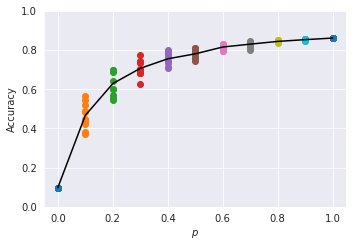

In [52]:
ave = np.average(acc_df.values, axis=0)
for i in range(acc_df.shape[1]):
    x = np.ones_like(acc_df.values[:,i]) * float(acc_df.columns[i])
    y = acc_df.values[:,i]
    plt.scatter(x, y, label=r"$p={:.1f}$".format(float(acc_df.columns[i])))

plt.plot([float(_p) for _p in acc_df.columns], ave, label="average", color="black")
plt.ylim(0., 1.)
plt.ylabel("Accuracy")
plt.xlabel("$p$")
plt.rcParams['figure.subplot.bottom'] = 0.2
plt.rcParams['figure.subplot.left'] = 0.2
#plt.legend()
plt.savefig("out/fig.png", dpi=300)

# 検光子モデル

In [53]:
def create_model(**kwargs):
    shape = (100, 100)
    theta = kwargs["theta"]
    eta = 0.
    l1=1.0e-6
    tf.random.set_seed(kwargs["seed"])
    inputs = tf.keras.Input((28, 28))
    x = ImageResizing(shape)(inputs)
    x = IntensityToElectricField(shape)(x)
    x = BinarizedMO(shape, theta=theta, eta=eta, beta=5.)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = BinarizedMO(shape, theta=theta, eta=eta, beta=5.)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = BinarizedMO(shape, theta=theta, eta=eta, beta=5.)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = BinarizedMO(shape, theta=theta, eta=eta, beta=5.)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = BinarizedMO(shape, theta=theta, eta=eta, beta=5.)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=n, method='expand', normalization="max")(x)
    x = Polarizer(shape, trainable=True)(x)
    x = ElectricFieldToIntensity(shape)(x)
    x = MNISTDetector(shape)(x)
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs, x)
    return model

In [56]:
def train(seed, theta, num):
    model_name = "20221021_" + str(num)
    cholab_path = "/content/drive/MyDrive/D2NN/"
    checkpoint_path = "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    path = "trained_model/"+ model_name

    model = create_model(seed=seed, theta=theta)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,  # category: sparse_categorical_crossentropy
                  metrics=["accuracy"]
                  )

    epochs = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=0.0002,
            patience=2,
        )

    def lr_schedule(epoch):
      """
      Returns a custom learning rate that decreases as epochs progress.
      """
      start = 0.2
      end = 0.0001
      n = 50
      a = -1/(n-1) * np.log(end/start)
      return np.exp(-a*(epoch)) * start
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(cholab_path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[lr_callback ,cp_callback, tensorboard_callback]
                       )

    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")



    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

In [ ]:
train(seed=1, theta=np.pi/100., num=2)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing_7 (ImageResi  (None, 100, 100)         0         
 zing)                                                           
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _7 (IntensityToElectricFiel                                     
 d)                                                              
                                                                 
 binarized_mo_30 (BinarizedM  (None, 2, 100, 100)      10000     
 O)                                                              
                                                                 
 angular_spectrum_30 (Angula  (None, 2, 100, 100)      0   